In [69]:
t_nucleo_exp_inches = 0.11
t_nucleo_exp = t_nucleo_exp_inches * 25.4

Tau_jorge_inches = 0.191
Tau_jorge = Tau_jorge_inches * 25.4

In [70]:
t_nucleo_exp

2.794

In [71]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize,basinhopping
import numpy as np

In [72]:

df = pd.read_csv('../experimental.csv', sep='\t')

In [73]:
df = df[["Nombre","Modulo Tracción [MPa]","Espesor (mm)"]]
# change column names to E[MPa] and t[mm]
df.columns = ['Name', 'E [MPa]', 't [mm]']
# GPa
df["E [GPa]"] = df["E [MPa]"] / 1000
df.drop(columns=["E [MPa]"], inplace=True)
df.head()

,Name,t [mm],E [GPa]
0,TFP1-1,4.9,2.838353
1,TFP1-1,4.9,2.685491
2,TFP1-1,5.0,3.132684
3,TFP2-1,4.4,2.184874
4,TFP2-1,4.6,2.310839


In [74]:
df_stats = df.groupby('Name').agg(['mean', 'std'])



In [75]:
composition = [
        ["Y","Y"],
        ["Y", "X"],
        ["Y", "SX"],
        ["Y", "SY"],
        ["Y","SX", "SY"],
        ["Y","X", "SY"]
    ]
df_stats["layers"] = composition

In [76]:
df_stats

t [mm]             E [GPa]                 layers
            mean       std      mean       std             
Name                                                       
TFP1-1  4.933333  0.057735  2.885509  0.227295       [Y, Y]
TFP2-1  4.500000  0.100000  2.258503  0.065626       [Y, X]
TFP3-1  4.900000  0.200000  2.000437  0.004435      [Y, SX]
TFP4-1  4.500000  0.000000  2.451362  0.114353      [Y, SY]
TFP5-1  5.733333  0.115470  1.626582  0.120272  [Y, SX, SY]
TFP6-1  5.533333  0.057735  1.739870  0.067515   [Y, X, SY]

<Axes: title={'center': 'Modulo Tracción [GPa]'}, xlabel='Name'>

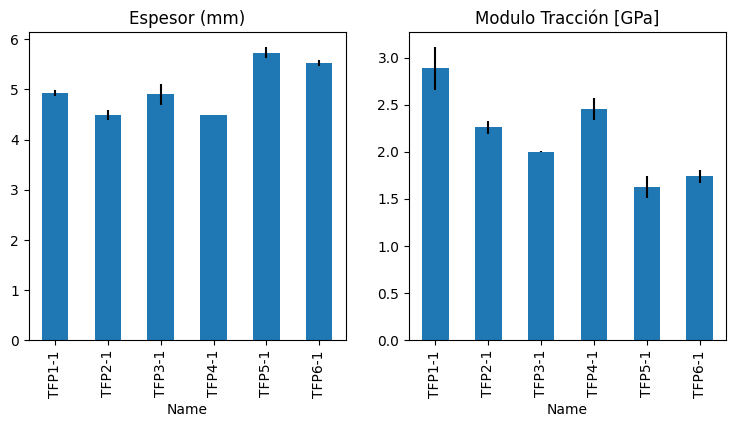

In [77]:
# plot bars with error bars Espesor (mm)
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(121)
df_stats['t [mm]'].plot(kind='bar', y='mean', yerr='std', legend=False, title='Espesor (mm)', ax=ax)
# plot bars with error bars Modulo Tracción [MPa]
ax = fig.add_subplot(122)
df_stats['E [GPa]'].plot(kind='bar', y='mean', yerr='std', legend=False, title='Modulo Tracción [GPa]', ax=ax)

In [78]:
df_stats

t [mm]             E [GPa]                 layers
            mean       std      mean       std             
Name                                                       
TFP1-1  4.933333  0.057735  2.885509  0.227295       [Y, Y]
TFP2-1  4.500000  0.100000  2.258503  0.065626       [Y, X]
TFP3-1  4.900000  0.200000  2.000437  0.004435      [Y, SX]
TFP4-1  4.500000  0.000000  2.451362  0.114353      [Y, SY]
TFP5-1  5.733333  0.115470  1.626582  0.120272  [Y, SX, SY]
TFP6-1  5.533333  0.057735  1.739870  0.067515   [Y, X, SY]

In [79]:
# [X]       -> [1,0,0,0]
# [X, SX]   -> [1,0,1,0]
# [X, Y]    -> [1,1,0,0]
# [X, SY]       -> [1,0,0,1]
# [X, SX, SY]   -> [1,0,1,1]
# [X, Y, SY]    -> [1,1,0,1]

def get_vector(list_of_layers):
    vector = [0,0,0,0]
    if "X" in list_of_layers:
        vector[0] = 1
    if "SX" in list_of_layers:
        vector[1] = 1
    if "Y" in list_of_layers:
        vector[2] = 1
    if "SY" in list_of_layers:
        vector[3] = 1

    return vector


In [80]:

df_stats['v [X,SX,Y,SY]'] = df_stats['layers'].apply(get_vector)
df_stats["ni"] = df_stats["layers"].apply(len)
df_stats

t [mm]             E [GPa]                 layers v [X,SX,Y,SY] ni
            mean       std      mean       std                              
Name                                                                        
TFP1-1  4.933333  0.057735  2.885509  0.227295       [Y, Y]  [0, 0, 1, 0]  2
TFP2-1  4.500000  0.100000  2.258503  0.065626       [Y, X]  [1, 0, 1, 0]  2
TFP3-1  4.900000  0.200000  2.000437  0.004435      [Y, SX]  [0, 1, 1, 0]  2
TFP4-1  4.500000  0.000000  2.451362  0.114353      [Y, SY]  [0, 0, 1, 1]  2
TFP5-1  5.733333  0.115470  1.626582  0.120272  [Y, SX, SY]  [0, 1, 1, 1]  3
TFP6-1  5.533333  0.057735  1.739870  0.067515   [Y, X, SY]  [1, 0, 1, 1]  3

In [81]:
df_stats[["layers", "v [X,SX,Y,SY]", "ni"]]

,layers,"v [X,SX,Y,SY]",ni
,,,
Name,,,
TFP1-1,"[Y, Y]","[0, 0, 1, 0]",2
TFP2-1,"[Y, X]","[1, 0, 1, 0]",2
TFP3-1,"[Y, SX]","[0, 1, 1, 0]",2
TFP4-1,"[Y, SY]","[0, 0, 1, 1]",2
TFP5-1,"[Y, SX, SY]","[0, 1, 1, 1]",3
TFP6-1,"[Y, X, SY]","[1, 0, 1, 1]",3


In [82]:
# only thin 

ni = df_stats["ni"].values
tau_exp = df_stats["t [mm]"]["mean"].values
print(ni )
tau_pred_fcn = lambda tn,tl: tn + 2*tl*ni

[2 2 2 2 3 3]


In [83]:

from Composite.CreateLines.BasicLines import BasicLines


lines = {
    "r": 2.5,
    "Nx_sq": 1,
    "Ny_sq": 1,
    "type":  'sin' # 'circle' or 'sin'
}

lines = BasicLines(lines)

In [84]:
lines.keys()

dict_keys(['trajs_X', 'trajs_Y', 'trajs_SX', 'trajs_SY', 'trajs_SX_smooth', 'trajs_SY_smooth', 'Lx', 'Ly', 'longs'])

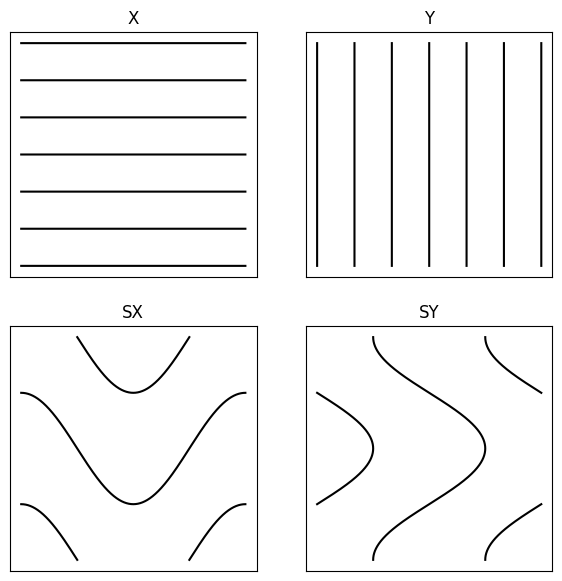

In [85]:
fig = plt.figure(figsize=(7, 7))
for k,layer in enumerate(lines.keys()):
    # if start with trajs plt
    if k >= 4:
        break
    if layer.startswith("trajs"):
        plt.subplot(2,2,k+1)

        for il in lines[layer]:
            plt.plot(il[:,0], il[:,1], 'k-')
        plt.title(layer.replace("trajs_",""))
        # no ticks
        plt.xticks([])
        plt.yticks([])

C:\Users\djoroya\AppData\Local\Temp\ipykernel_15504\4169359739.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for j,layer in enumerate(df_stats['layers'][i]):


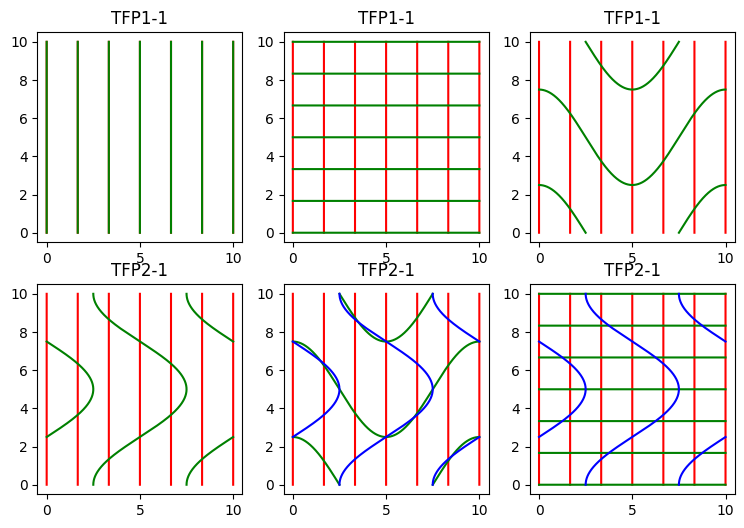

In [86]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
fig = plt.figure(figsize=(9,6))
for i in range(len(df_stats)):
    plt.subplot(2, 3, i+1)

    for j,layer in enumerate(df_stats['layers'][i]):
        for curve in lines["trajs_"+layer]:
            plt.plot(curve[:,0], 
                     curve[:,1],
                     color = colors[j],
                        label = layer) 
    plt.title(df['Name'][i])
    

In [87]:
def E_effective_j(tn,tl,En,Evec,j):
    
    tau_pred = tau_pred_fcn(tn,tl)

    delta_j  = df_stats["v [X,SX,Y,SY]"].iloc[j]

    tau_j    = tau_pred[j]

    return (En*tn + 2*tl*(np.dot(delta_j,Evec)))/tau_j

def E_effective(En,Evec,tn,tl):
    return np.array([E_effective_j(tn,tl,En,Evec,j) 
                     for j in range(len(df_stats))])


In [88]:
E_eff_exp = df_stats["E [GPa]"]["mean"].values

Evec_0 = np.array([1,0,0,0])
En_0 = 100
tn_0 = 1
tl_0 = 1

E_eff_pred = E_effective(En_0,Evec_0,tn_0,tl_0)
tau_pred = tau_pred_fcn(tn_0,tl_0)

In [89]:
from validation.experimental import  nucleo

In [90]:
tau_pred

array([5, 5, 5, 5, 7, 7])

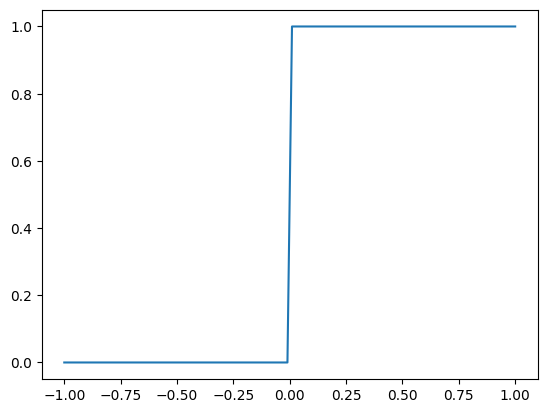

In [91]:
def theta(x):
    return 0.5*(np.sign(x)+1)

t_span = np.linspace(-1,1,100)
plt.plot(t_span,theta(t_span))

In [92]:
E_nucleo_exp_Mpa = nucleo()["young modulus [MPa]"]
E_nucleo_exp = E_nucleo_exp_Mpa/1000
print(E_nucleo_exp)

0.8


In [93]:
relu = lambda x: x*theta(x)

In [94]:
# minimize 
def objective_E(En,Evec,tn,tl):
    Loss_E   = sum((E_effective(En,Evec,tn,tl) - E_eff_exp)**2)
    Loss_tau = 1e-1*sum((tau_pred_fcn(tn,tl) - tau_exp)**2)
    
    # En < Evec[0]
    lag_mult = 1e6*relu( En - Evec[0]) # Asumimos que el nucleo es el material más blando que la capas E[0] -> X
    
    return Loss_E + Loss_tau + 0*lag_mult
           

x0 = np.random.rand(7)
# must be positive 

bounds = [  (E_nucleo_exp*0.9,1.1*E_nucleo_exp), # En
            (0.100,None), # Evec[0]   # X
            (0.100,None), # Evec[1]   # Y
            (0.100,None), # Evec[2]   # SX
            (0.100,None), # Evec[3]   # SY
            (0.9*t_nucleo_exp,1.1*t_nucleo_exp), # tn
            (0.25,2)  # tl
            ]

bounds = [  (E_nucleo_exp*0.9,1.1*E_nucleo_exp), # En
            (0.0,None), # Evec[0]   # X
            (0.0,None), # Evec[1]   # Y
            (0.0,None), # Evec[2]   # SX
            (0.0,None), # Evec[3]   # SY
            (0.9*t_nucleo_exp,1.1*t_nucleo_exp), # tn
            (0.25,2)  # tl
            ]
          
# set constraints
if x0[1] < x0[0]:
    x0[1] = x0[0]

for k,ib in enumerate(bounds):

    if ib[0] is not None and x0[k] < ib[0]:
        x0[k] = ib[0]
    if ib[1] is not None and x0[k] > ib[1]:
        x0[k] = ib[1]

minimizer_kwargs = {"method": "trust-constr",
                    "bounds": bounds}

res = basinhopping(lambda x: objective_E(x[0],x[1:5],x[5],x[6]),
                x0, 
                minimizer_kwargs=minimizer_kwargs,
                niter=50)

En_opt = res.x[0]
Evec_opt = res.x[1:5]
tn_opt = res.x[5]
tl_opt = res.x[6]


E_eff_pred = E_effective(En_opt,Evec_opt,tn_opt,tl_opt)
tau_pred   = tau_pred_fcn(tn_opt,tl_opt)

In [95]:
tau_pred

array([4.68853814, 4.68853814, 4.68853814, 4.68853814, 5.77550717,
       5.77550717])

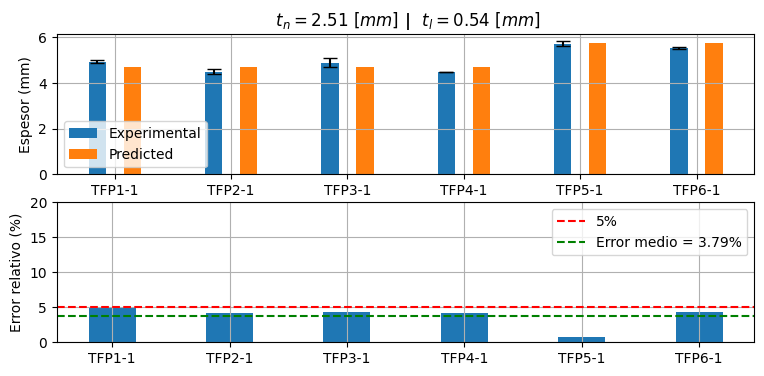

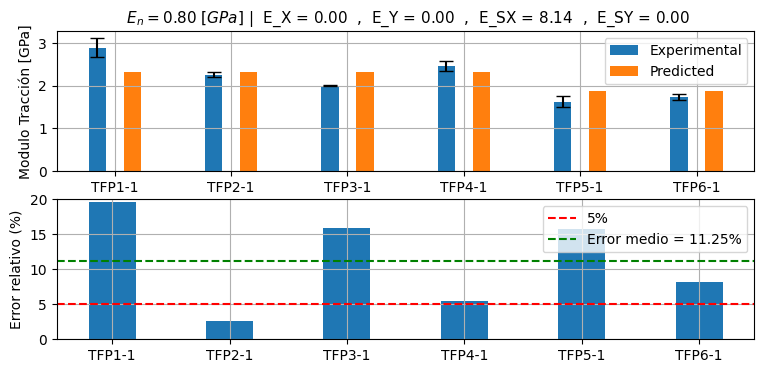

In [96]:
from AnalyticalLayers.plot_E import plot_E
from AnalyticalLayers.plt_thin import plt_thin

plt_thin(df_stats, tau_exp, tau_pred, tn_opt, tl_opt)
plot_E(df_stats, E_eff_exp, E_eff_pred, Evec_opt, En_opt)

In [97]:
df_layers = pd.DataFrame({"Evec [GPa]": Evec_opt}, index=["X","SX","Y","SY"])
# add nuclueo
df_layers.loc["Nucleo"] = [En_opt]
df_layers.round(2)

,Evec [GPa]
X,0.00
SX,0.00
Y,8.14
SY,0.00
Nucleo,0.80


In [98]:
df_thickness = pd.DataFrame({"t [mm]": [tn_opt, tl_opt]}, index=["Nucleo","Capas"])

df_thickness.round(2)

,t [mm]
Nucleo,2.51
Capas,0.54


In [99]:
print("Optimal En: ", En_opt)
print("Optimal Evec: ", Evec_opt)
print("Optimal tn: ", tn_opt)
print("Optimal tl: ", tl_opt)

Optimal En:  0.8027780630029674
Optimal Evec:  [8.35252520e-08 2.44075272e-08 8.14253615e+00 7.21363969e-09]
Optimal tn:  2.514600086663686
Optimal tl:  0.5434845132872463


In [100]:
130000*0.02

2600.0

In [101]:
df_pred = {
    "Name"          : df_stats.index,
    "E pred [GPa]"  : E_eff_pred,
    "E exp [GPa]"   : E_eff_exp,
    "E e rel [%]"   : 100*abs(E_eff_exp - E_eff_pred)/E_eff_exp,
    "t pred [mm]"   : tau_pred,
    "t exp [mm]"    : tau_exp,
    "t e rel [%]"   : 100*abs(tau_exp - tau_pred)/tau_exp
}
df_pred = pd.DataFrame(df_pred)
# decimals
df_pred = df_pred.round(2)
df_pred.head()

,Name,E pred [GPa],E exp [GPa],E e rel [%],t pred [mm],t exp [mm],t e rel [%]
0,TFP1-1,2.32,2.89,19.66,4.69,4.93,4.96
1,TFP2-1,2.32,2.26,2.65,4.69,4.50,4.19
2,TFP3-1,2.32,2.00,15.89,4.69,4.90,4.32
3,TFP4-1,2.32,2.45,5.43,4.69,4.50,4.19
4,TFP5-1,1.88,1.63,15.70,5.78,5.73,0.74


In [102]:
Em_error = np.mean(df_pred["E e rel [%]"])
tm_error = np.mean(df_pred["t e rel [%]"])

from loadsavejson.savejson import savejson

savejson({"layers":df_layers, 
            "errors": {"E":Em_error, "t":tm_error},
          "thickness":df_thickness},
          "df_opt_free_thin.json")